In [1]:
%matplotlib inline
import os, flopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

flopy is installed in /home/wk-gida1/.local/lib/python3.7/site-packages/flopy


In [2]:
wellLoc=pd.read_csv('../inputData/TV-HFM_Wells_1Location_Wgs11N.csv',index_col=0)
wellLoc.head()

Easting    Northing  Altitude_ft     EastingUTM  \
Bore                                                                
A. Isaac       2333140.95  1372225.65       3204.0  575546.628834   
A. Woodbridge  2321747.00  1360096.95       2967.2  564600.366582   
A.D. Watkins   2315440.16  1342141.86       3168.3  558944.843404   
A.L. Clark; 1  2276526.30  1364860.74       2279.1  519259.006159   
A.L. Clark; 2  2342620.87  1362980.46       3848.6  585351.150270   

                NorthingUTM  Elevation_m  
Bore                                      
A. Isaac       4.820355e+06    976.57920  
A. Woodbridge  4.807827e+06    904.40256  
A.D. Watkins   4.789664e+06    965.69784  
A.L. Clark; 1  4.810959e+06    694.66968  
A.L. Clark; 2  4.811460e+06   1173.05328

In [3]:
wellLito = pd.read_csv('../inputData/TV-HFM_Wells_2Lithology_m.csv')
wellLito.head()

Bore  Depth_top_L  Depth_bot_L PrimaryLith  topLitoElev_m  \
0  A. Isaac          0.0          1.0        Soil       976.5792   
1  A. Isaac          1.0         53.0        Sand       976.2744   
2  A. Isaac         53.0        248.0      Basalt       960.4248   
3  A. Isaac        248.0        265.0        Sand       900.9888   
4  A. Isaac        265.0        323.0      Basalt       895.8072   

   botLitoElev_m  
0       976.2744  
1       960.4248  
2       900.9888  
3       895.8072  
4       878.1288

In [4]:
#create a dictionary for the lito code
litoDict = {}
i=0
for lito in wellLito.PrimaryLith.unique():
    litoDict[lito]=i
    i+=1
litoDict

{'Soil': 0,
 'Sand': 1,
 'Basalt': 2,
 'Granite': 3,
 'Hardpan/Caliche': 4,
 'Cinders/Scoria': 5,
 'Gravel': 6,
 'Clay': 7,
 'Talc/Soapstone': 8,
 'Shale': 9,
 'Lignite/Coal/Peat': 10,
 'Sandstone': 11,
 'Lime': 12,
 'Claystone': 13,
 'Mud': 14,
 'Ash/Tuff': 15,
 'Mudstone': 16,
 'Rhyolite': 17,
 'Siltstone': 18,
 'Silt': 19,
 'Shell': 20,
 'Conglomerate': 21,
 'Volcanics': 22,
 'Chert': 23,
 'Pyrite': 24,
 'Limestone/marl': 25,
 'Wood': 26,
 'Andesite': 27}

In [5]:
#identify lito by the code on the dataframe
wellLito['litoCode']=wellLito.PrimaryLith
wellLito = wellLito.replace({"litoCode": litoDict})
wellLito.head()

Bore  Depth_top_L  Depth_bot_L PrimaryLith  topLitoElev_m  \
0  A. Isaac          0.0          1.0        Soil       976.5792   
1  A. Isaac          1.0         53.0        Sand       976.2744   
2  A. Isaac         53.0        248.0      Basalt       960.4248   
3  A. Isaac        248.0        265.0        Sand       900.9888   
4  A. Isaac        265.0        323.0      Basalt       895.8072   

   botLitoElev_m  litoCode  
0       976.2744         0  
1       960.4248         1  
2       900.9888         2  
3       895.8072         1  
4       878.1288         2

---
Setting hydrogeological units

From the publicacion:
https://pubs.usgs.gov/sir/2019/5138/sir20195138_v1.1.pdf
The selected units would be:
1. Coarse-grained fluvial and alluvial deposits
2. Pliocene-Pleistocene and Miocene basalts
3. Fine-grained lacustrine deposits
4. Rhyolitic and granitic bedrock  

In [6]:
wellLito['hydrogeoCode']=''
for index, values in wellLito.iterrows():
    #For Coarse-grained: Soil, Sand, Caliche, Scoria, Gravel, Peat, Wood, Ash 
    if values.litoCode in [0, 1, 4, 5, 6, 10, 26, 15]:
        wellLito.loc[index,'hydrogeoCode']=1
    #For basalts and other sedimentary rocks: Basalt, Soapstone, Shale, Sandstone, Claystone, Mudstone, Siltstone, Conglomerate, Volcanics, Pyrite, Limestone
    elif values.litoCode in [2, 8, 9, 11, 13, 16, 18, 21, 22, 24, 25]:
        wellLito.loc[index,'hydrogeoCode']=2
    #For fine-grained deposits: Clay, Lime, Mud, Silt, Shell, Chert
    elif values.litoCode in [7, 12, 14, 19, 20, 23]:
        wellLito.loc[index,'hydrogeoCode']=3
    #For rhyolitic and granitic bedrock: Granite, rhyolite, andesite
    elif values.litoCode in [3,17,27]:
        wellLito.loc[index,'hydrogeoCode']=4
    else:
        print('The following litcode has no equivalent'+str(vaues.litoCode))
wellLito.head()
wellLito.to_csv('../inputData/TV-HFM_Wells_2Lithology_m_reclass.csv')

---
### Clip to the area of study

In [7]:
#Area of study extension
xMin = 540000
xMax = 560000
yMin = 4820000
yMax = 4840000
xMean = (xMax+xMin)/2
yMean = (yMax+yMin)/2

In [8]:
from shapely.geometry import Polygon,Point
aoiGeom = Polygon([(xMin,yMin),(xMax,yMin),(xMax,yMax),
                  (xMin,yMax),(xMin,yMin),])

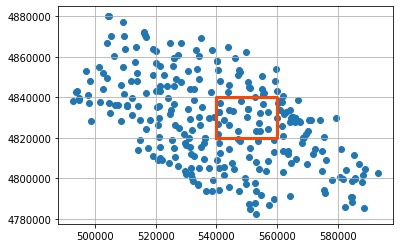

In [9]:
#show al points
fig, ax = plt.subplots()
ax.scatter(wellLoc.EastingUTM,wellLoc.NorthingUTM)
ax.plot(*aoiGeom.exterior.xy,linewidth=3,color='orangered')
ax.grid()

In [10]:
for index, values in wellLito.iterrows():
    x, y =wellLoc.loc[values.Bore][['EastingUTM','NorthingUTM']]
    wellPoint = Point(x,y)
    if wellPoint.within(aoiGeom):
        pass
    else:
        wellLito.drop(index, inplace=True)
wellLito.describe()

Depth_top_L  Depth_bot_L  topLitoElev_m  botLitoElev_m    litoCode  \
count   479.000000   479.000000     479.000000     479.000000  479.000000   
mean    505.188935   539.123173     638.523802     628.180646    5.231733   
std     703.329089   731.570322     218.380948     227.012375    4.855501   
min       0.000000     1.000000    -323.240400    -372.008400    0.000000   
25%      80.000000    94.500000     585.094080     568.238640    1.000000   
50%     238.000000   264.000000     711.921360     701.466720    6.000000   
75%     717.500000   747.500000     767.334000     762.716280    7.000000   
max    3615.000000  3775.000000     839.144880     838.840080   21.000000   

       hydrogeoCode  
count    479.000000  
mean       1.885177  
std        0.910980  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max        4.000000

---

### Vtk representation

In [14]:
import pyvista as pv
#generation of list arrays for the vtk
offsetList = []
linSec = []
linVerts = []

i=0
for index, values in wellLito.iterrows():
    x, y =wellLoc.loc[values.Bore][['EastingUTM','NorthingUTM']]
    cellVerts = [[x,y,values.topLitoElev_m],[x,y,values.botLitoElev_m]]
    offsetList.append(i*3)         
    linSec = linSec + [2,2*i,2*i+1]
    linVerts = linVerts + cellVerts
    i +=1

offsetArray = np.array(offsetList)
linArray = np.array(linSec)
cellType = np.ones([i])*3
vertArray = np.array(linVerts)
# create the unstructured grid and assign lito code
grid = pv.UnstructuredGrid(offsetArray, linArray, cellType, vertArray)
grid.cell_arrays["values"] = wellLito.hydrogeoCode.values
grid.save('../outputData/conceptualizedLito.vtu',binary=False)

1